In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from datetime import datetime
import numpy as np
import warnings
from scipy.optimize import curve_fit

from ts_viz import TimeSeriesViz

In [50]:
# func = lambda x, a, b: a * np.exp(b * x) 
# func_name = 'exp'

func = lambda t, K, x, t0: K * np.power(t, x) * np.exp(-t / t0) 
func_name = 'power'

def show_fit(series, func=False, func_name=False, title=None, pred=7, sma=False, figsize=(10, 6)):
    x = np.arange(len(series))
    index = pd.date_range(series.index.min(), periods=(len(series) + pred), freq='D')
    if func:    
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            popt, pcov = curve_fit(func, x, series.values, maxfev=2000, p0=(1, 1, 5))
        y = func(np.arange(len(index)), *popt)
        fit = pd.Series(y, index=index)
        err = np.sqrt(np.sum((fit[:-pred] - series) ** 2) / len(series))
        print(f'Fit error: {err:.02f}')
        print(f'Predicted volume error: {1 - fit[:-pred].sum() / series.sum():.02%}')

    fig, ax = plt.subplots(figsize=figsize)
    if func:
        ax.plot(index, y, label=f'{func_name} fit', color='tab:red', lw=2)
        ax.axvline(index[np.argmax(fit)], color='tab:red')

    ax.bar(series.index, series, label=series.name)
    
    if sma:
        sma_series = series.rolling(sma, center=True).mean()
        ax.plot(sma_series.index, sma_series, label=f'Moving avg ({sma} days)', color='tab:red', lw=2)
    
#     locator = mdates.DayLocator(interval=7)
#     locator = mdates.WeekdayLocator(byweekday=mdates.MO)
    locator = mdates.MonthLocator(bymonthday=[1, 5, 10, 15, 20, 25])
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.set_ylim(0, None)
    if title:
        ax.set_title(title)
    plt.legend(loc='upper left')
    if func:
        return (fig, ax), popt, pcov, fit
    else:
        return (fig, ax), None, None, None

In [51]:
today = (datetime.now() - dt.timedelta(days=0)).strftime('%Y-%m-%d')
world_url = f'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{today}.xlsx'
print(world_url)
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df_raw = pd.read_excel(world_url, parse_dates=['dateRep'], index_col=0)
print(df_raw.index.max())
df_raw = df_raw[['cases', 'deaths', 'countriesAndTerritories']]
df_raw.columns = ['cases', 'deaths', 'country']
df_raw = df_raw.sort_index()
df_raw[df_raw['country'] == 'Hungary'].tail()

https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-10-28.xlsx


KeyboardInterrupt: 

In [4]:
df = df_raw.groupby('country').sum()

In [5]:
df.to_csv(f'data/world-{today}.csv')

In [6]:
def show_new(series, title, figsize=(16, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(series.index, series, align='center')
    ax.set_title(title)
    ax.yaxis.grid(True, which='major')
    locator = mdates.DayLocator(interval=1)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.set_xlim((series.index.min() + pd.Timedelta(days=.5), series.index.max() + pd.Timedelta(days=.5)))

In [7]:
class CountryViz:

    def __init__(self, country, start, df_raw, fit_func=False, fit_func_name=False):
        self.country = country
        self.start = start
        self.fit_func = fit_func
        self.fit_func_name = fit_func_name
        self.df =  df_raw[(df_raw['country'] == country) & (df_raw.index > start)].sort_index()
        self.cases = self.df['cases'].copy()
        self.deaths = self.df['deaths'].copy()

    def _show_diag(self, series, name):
        (fig, ax), popt, pcov, y = show_fit(series, self.fit_func, self.fit_func_name, 
                                      title=f'{name} in {self.country}', sma=7, figsize=(16, 10))
        if self.fit_func:
            K, x, t0 = popt
            print(f'{self.country}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
            print(f'first day: {self.cases.index[0]:%Y-%m-%d}')
            print(f'peak as of fit: {y.index[np.argmax(y)]:%Y-%m-%d}')
        print(f'\n{name} data:')
        print(series.tail())
        return fig, ax
        
        
    def show_cases(self):
        return self._show_diag(self.cases, 'New daily cases')
        
    def show_deaths(self):
        return self._show_diag(self.deaths, 'Daily deaths')


New daily cases data:
dateRep
2020-10-24    42032
2020-10-25    45422
2020-10-26    52010
2020-10-27    26771
2020-10-28    33417
Name: cases, dtype: int64


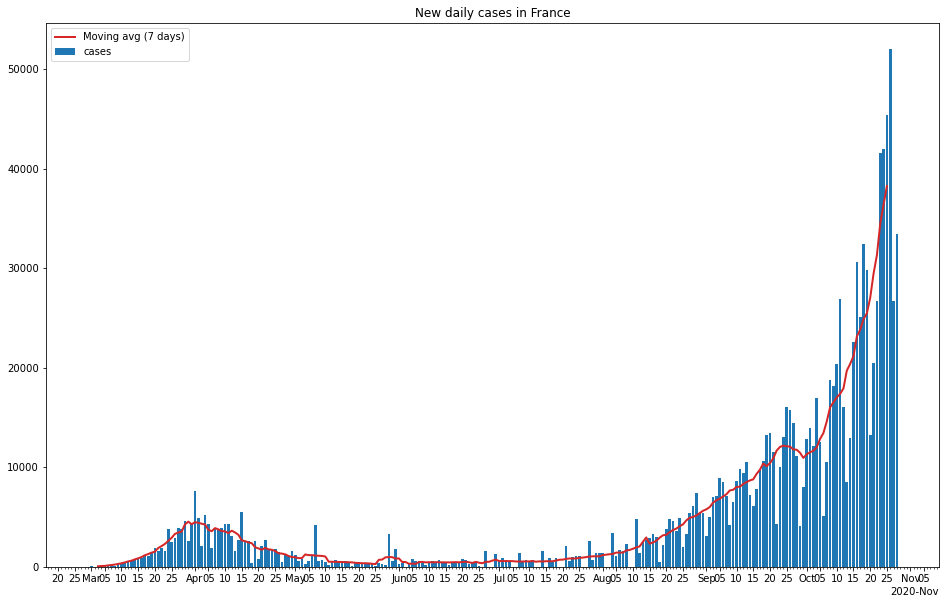

In [52]:
france = CountryViz('France', '2020-02-28', df_raw)
fig, ax = france.show_cases()
plt.show()


Daily deaths data:
dateRep
2020-10-24    298
2020-10-25    137
2020-10-26    116
2020-10-27    257
2020-10-28    523
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in France'}>)

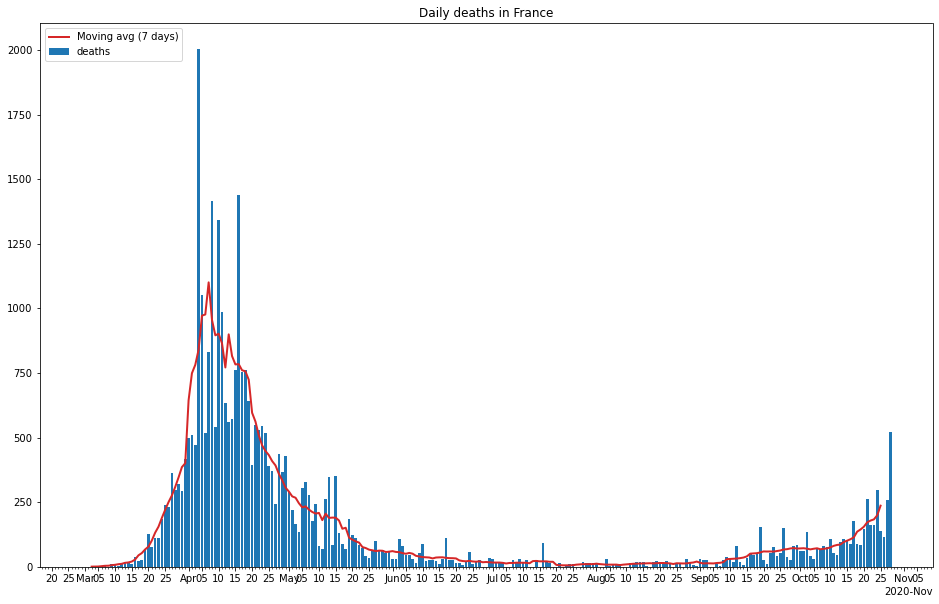

In [53]:
france.show_deaths()


New daily cases data:
dateRep
2020-10-24    1820
2020-10-25    3149
2020-10-26    2316
2020-10-27    2079
2020-10-28    2291
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Hungary'}>)

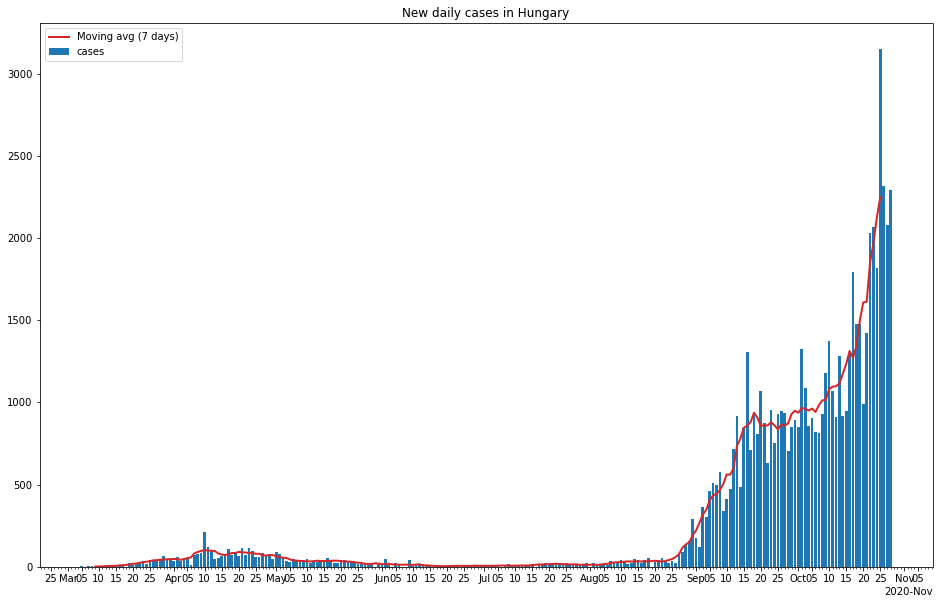

In [54]:
hun = CountryViz('Hungary', '2020-02-28', df_raw)
hun.show_cases()


Daily deaths data:
dateRep
2020-10-24    38
2020-10-25    35
2020-10-26    47
2020-10-27    63
2020-10-28    43
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in Hungary'}>)

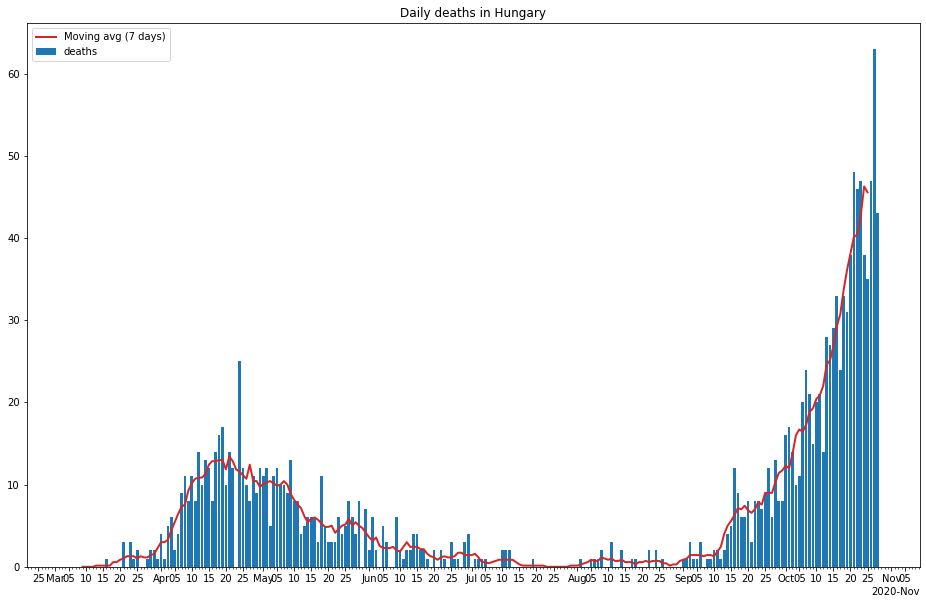

In [55]:
hun.show_deaths()


New daily cases data:
dateRep
2020-10-23    19851
2020-10-24        0
2020-10-25        0
2020-10-26    52188
2020-10-27    18418
Name: cases, dtype: int64


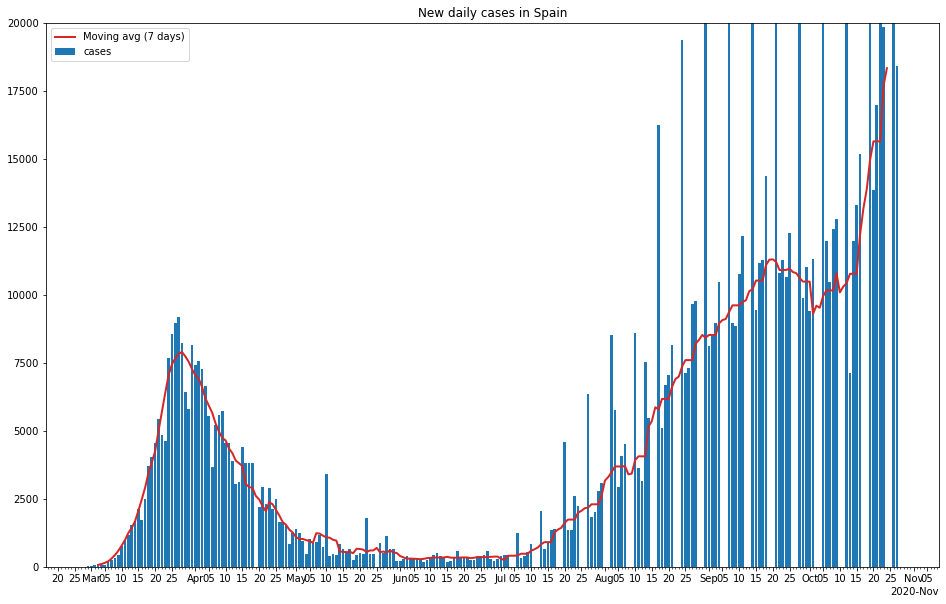

In [56]:
spain = CountryViz('Spain', '2020-02-28', df_raw)
fig, ax = spain.show_cases()
ax.set_ylim(0, 20000)
plt.show()


Daily deaths data:
dateRep
2020-10-23    231
2020-10-24      0
2020-10-25      0
2020-10-26    279
2020-10-27    267
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in Spain'}>)

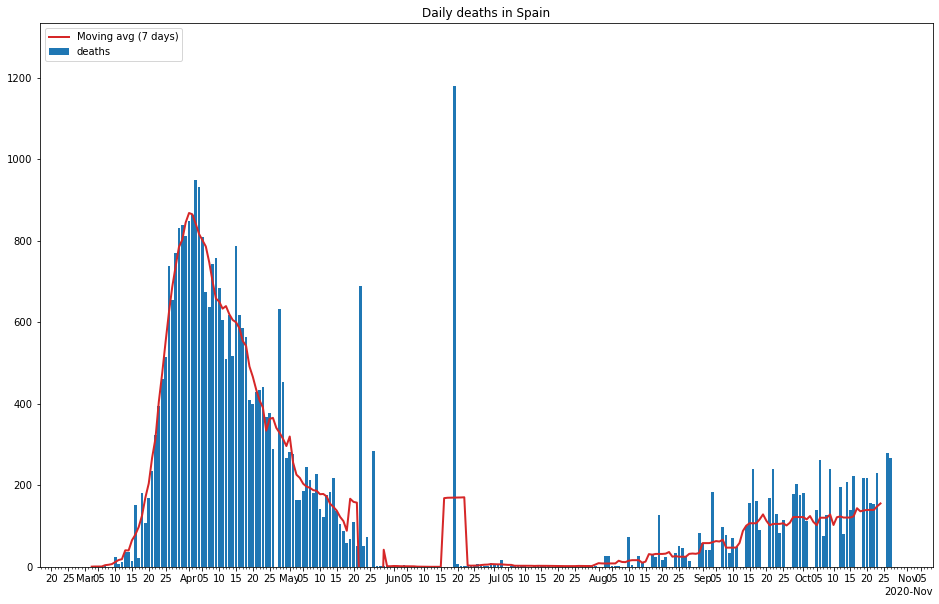

In [57]:
spain.show_deaths()


New daily cases data:
dateRep
2020-10-24    20531
2020-10-25    23012
2020-10-26    19790
2020-10-27    20890
2020-10-28    22885
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in United_Kingdom'}>)

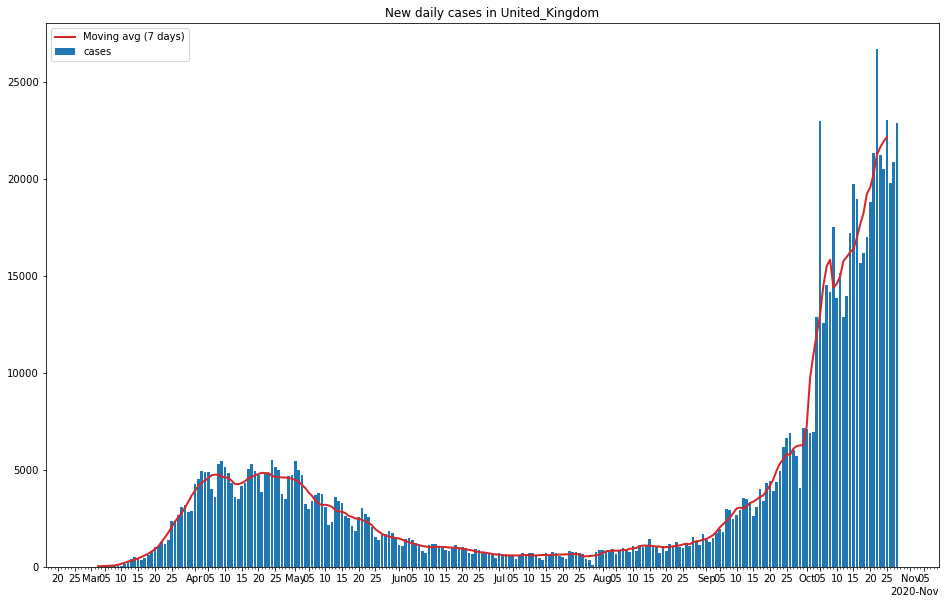

In [58]:
uk = CountryViz('United_Kingdom', '2020-02-28', df_raw)
uk.show_cases()


Daily deaths data:
dateRep
2020-10-24    224
2020-10-25    174
2020-10-26    151
2020-10-27    102
2020-10-28    367
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in United_Kingdom'}>)

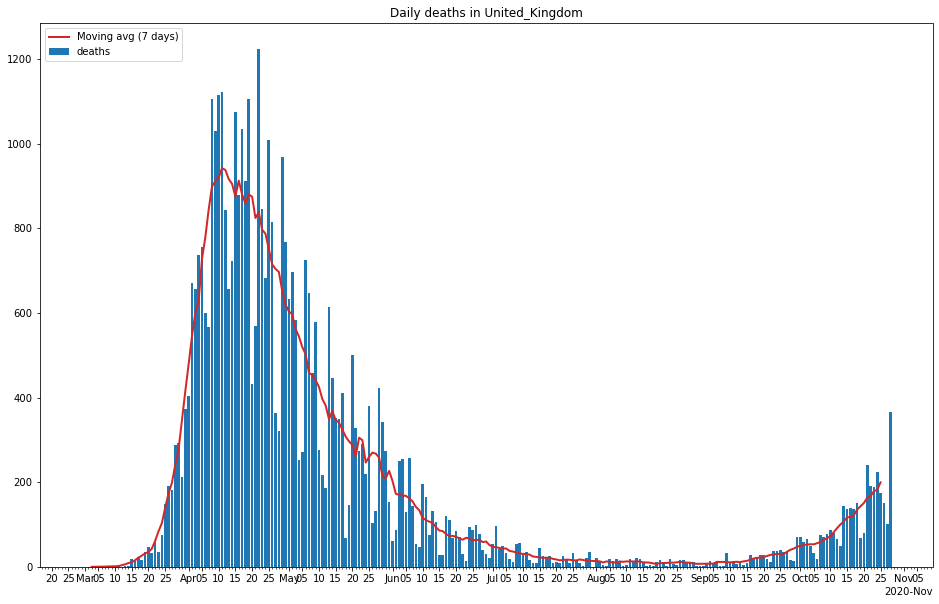

In [59]:
uk.show_deaths()


New daily cases data:
dateRep
2020-10-24    85329
2020-10-25    83056
2020-10-26    59440
2020-10-27    68359
2020-10-28    75129
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in United_States_of_America'}>)

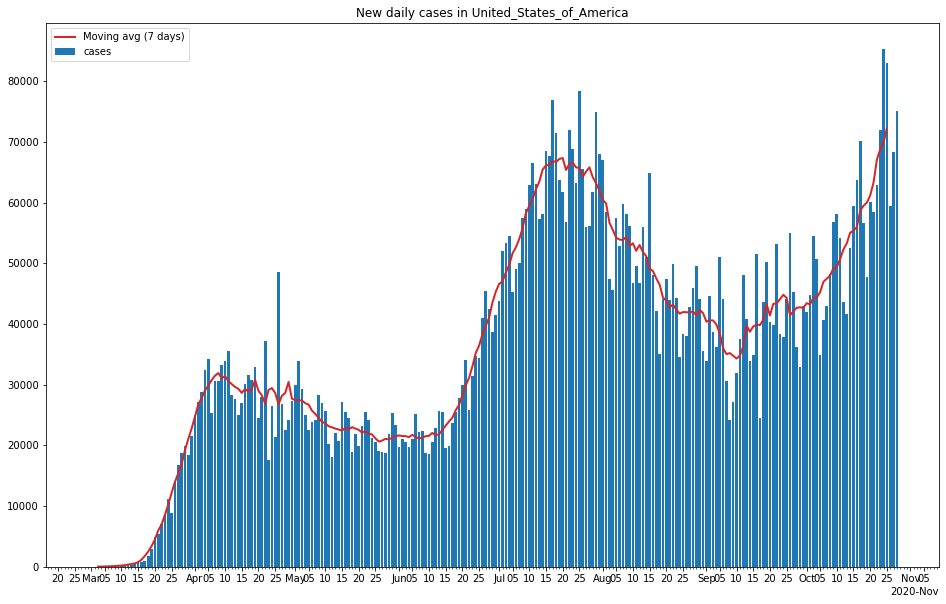

In [60]:
usa = CountryViz('United_States_of_America', '2020-02-28', df_raw)
usa.show_cases()


Daily deaths data:
dateRep
2020-10-24    953
2020-10-25    904
2020-10-26    331
2020-10-27    505
2020-10-28    988
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in United_States_of_America'}>)

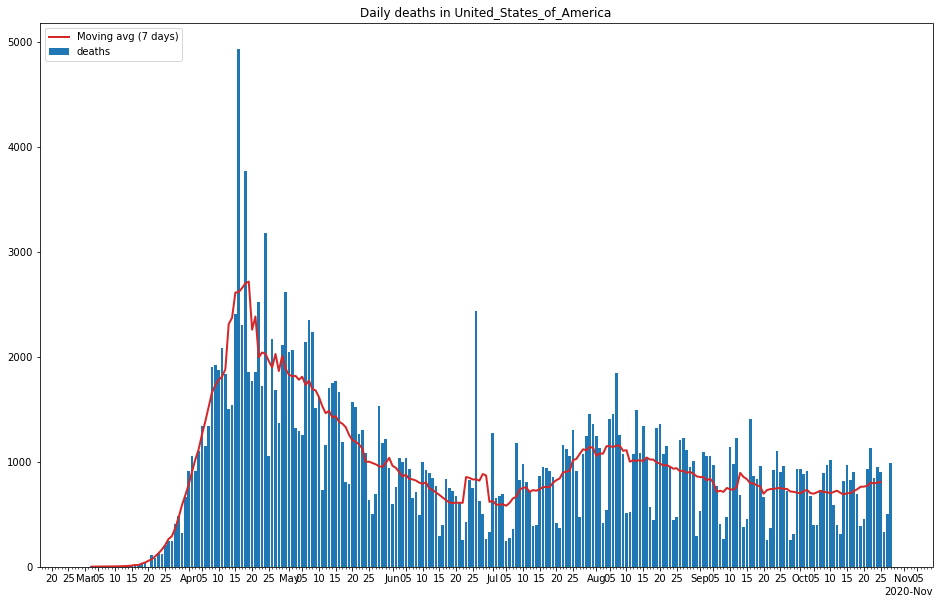

In [61]:
usa.show_deaths()


New daily cases data:
dateRep
2020-10-24    19143
2020-10-25    19640
2020-10-26    21273
2020-10-27    17007
2020-10-28    21989
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Italy'}>)

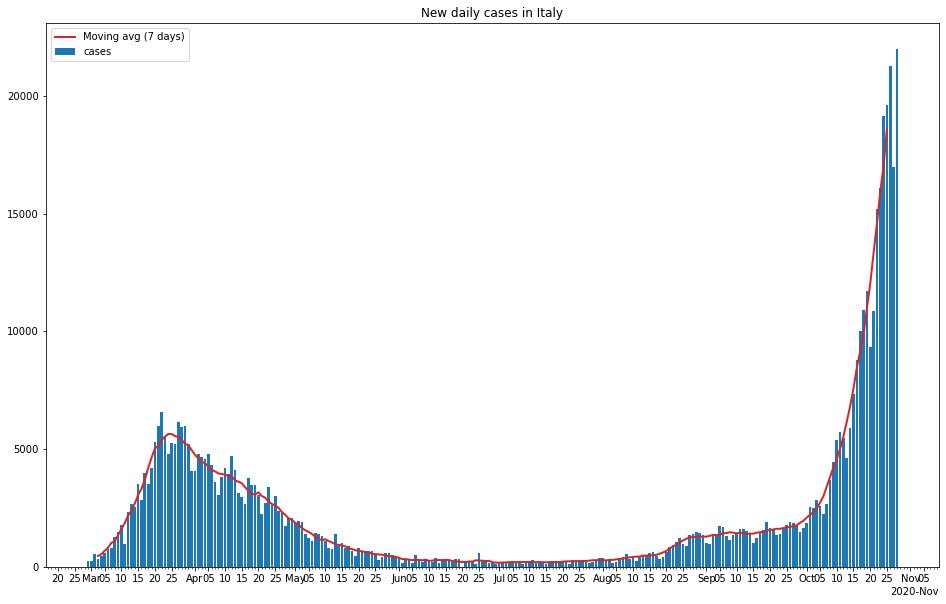

In [62]:
it = CountryViz('Italy', '2020-02-28', df_raw)
it.show_cases()


Daily deaths data:
dateRep
2020-10-24     91
2020-10-25    151
2020-10-26    128
2020-10-27    141
2020-10-28    221
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in Italy'}>)

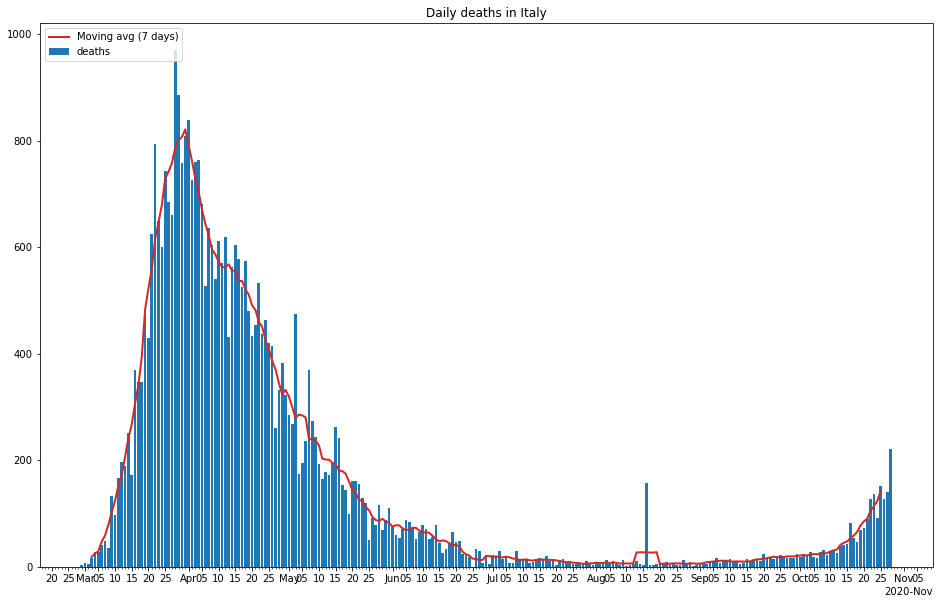

In [63]:
it.show_deaths()


New daily cases data:
dateRep
2020-10-24    1870
2020-10-25    1478
2020-10-26     516
2020-10-27     922
2020-10-28       0
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Sweden'}>)

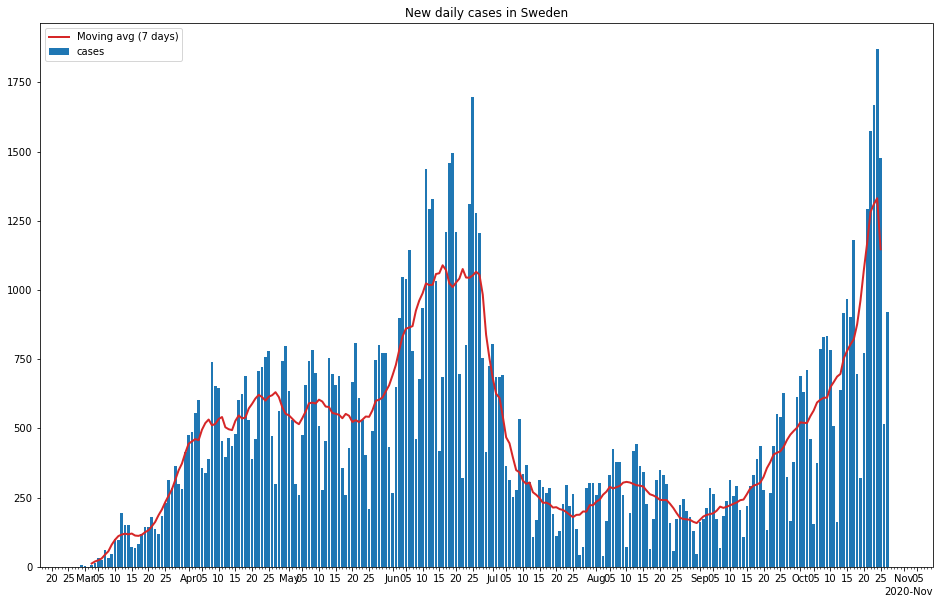

In [64]:
sw = CountryViz('Sweden', '2020-02-28', df_raw)
sw.show_cases()


Daily deaths data:
dateRep
2020-10-24    2
2020-10-25    0
2020-10-26    2
2020-10-27    1
2020-10-28    0
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in Sweden'}>)

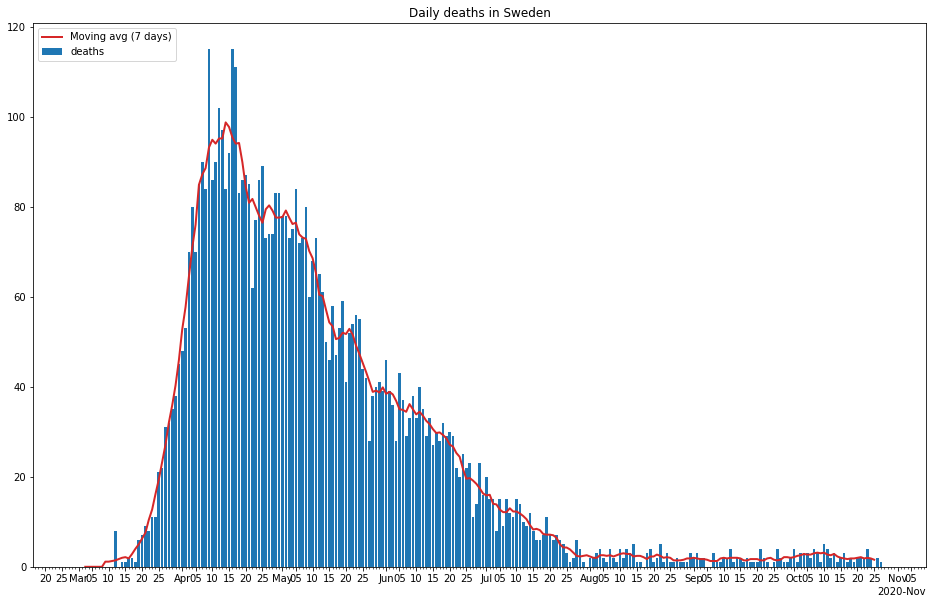

In [65]:
sw.show_deaths()


New daily cases data:
dateRep
2020-10-24    14714
2020-10-25    11176
2020-10-26     8685
2020-10-27    11409
2020-10-28    14964
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Germany'}>)

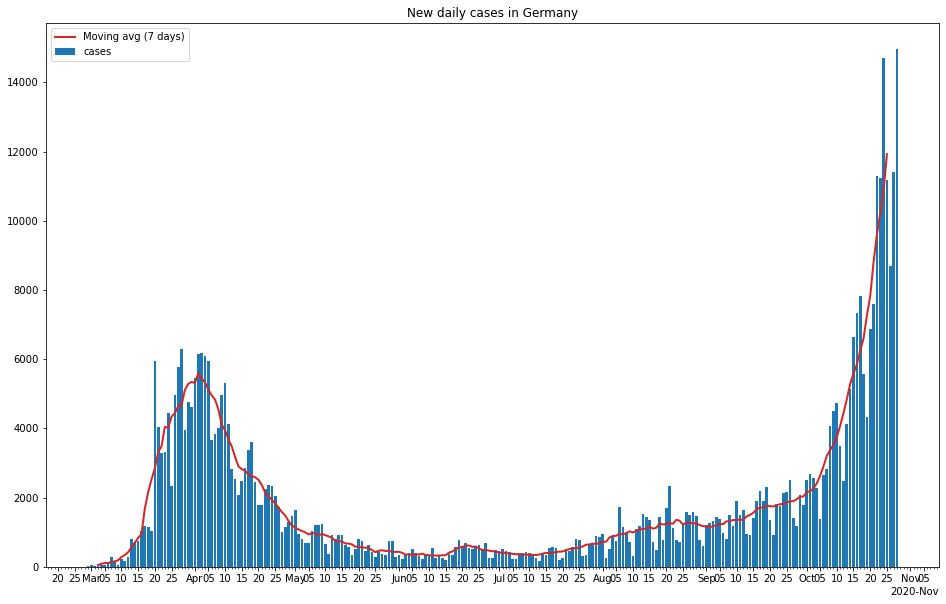

In [66]:
ger = CountryViz('Germany', '2020-02-28', df_raw)
ger.show_cases()


Daily deaths data:
dateRep
2020-10-24    49
2020-10-25    29
2020-10-26    24
2020-10-27    42
2020-10-28    85
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in Germany'}>)

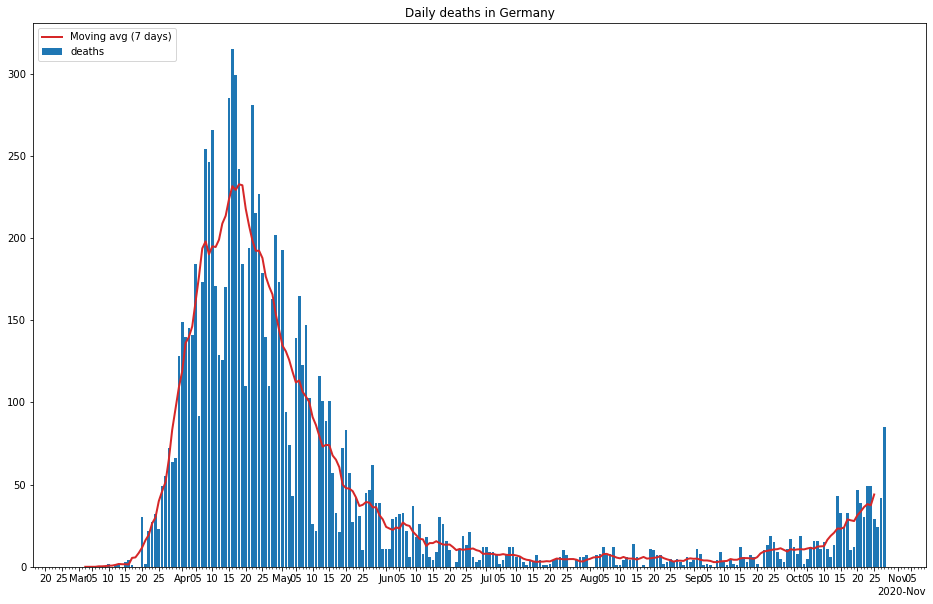

In [67]:
ger.show_deaths()


New daily cases data:
dateRep
2020-10-24    40
2020-10-25    86
2020-10-26    54
2020-10-27    56
2020-10-28    70
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Iceland'}>)

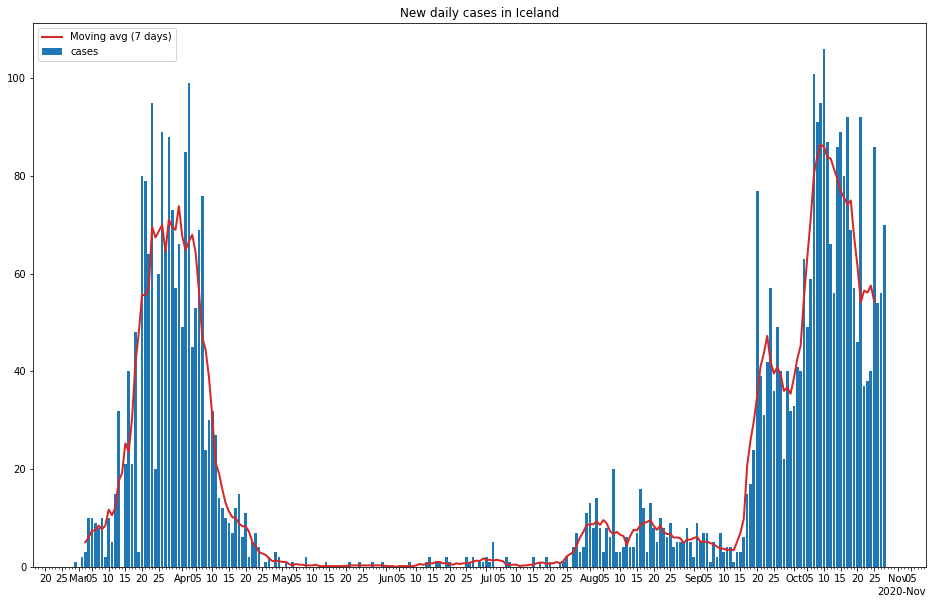

In [68]:
ice = CountryViz('Iceland', '2020-02-28', df_raw)
ice.show_cases()


New daily cases data:
dateRep
2020-10-24    10
2020-10-25    14
2020-10-26     5
2020-10-27     3
2020-10-28     7
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Singapore'}>)

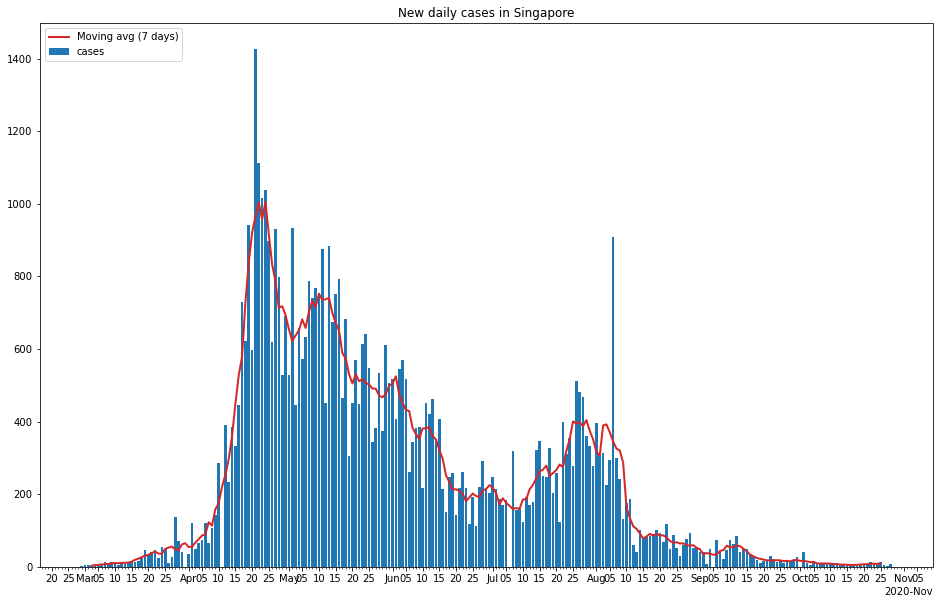

In [69]:
sing = CountryViz('Singapore', '2020-02-28', df_raw)
sing.show_cases()


New daily cases data:
dateRep
2020-10-24     77
2020-10-25     61
2020-10-26    119
2020-10-27     88
2020-10-28    103
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in South_Korea'}>)

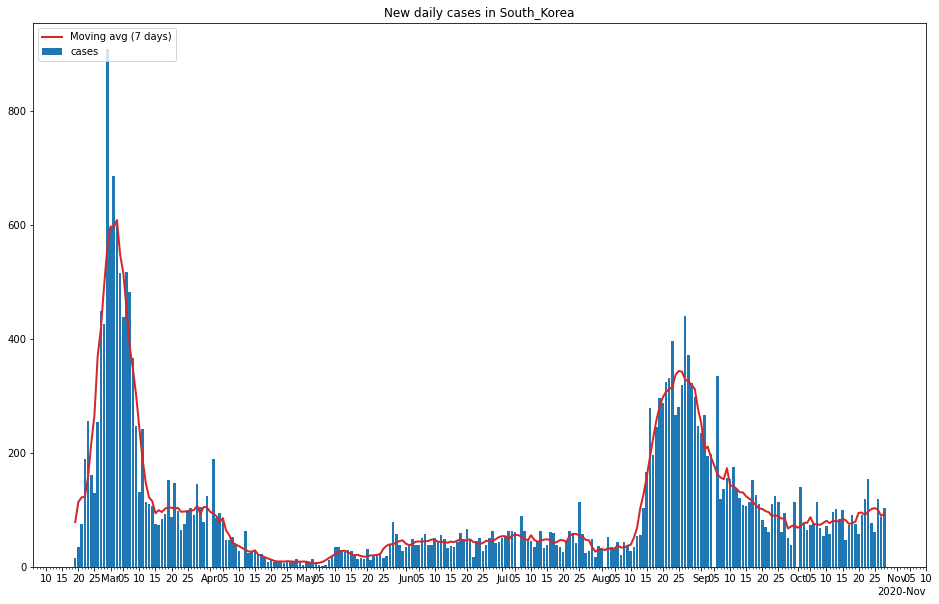

In [26]:
sk = CountryViz('South_Korea', '2020-02-18', df_raw)
sk.show_cases()


Daily deaths data:
dateRep
2020-10-24    2
2020-10-25    0
2020-10-26    0
2020-10-27    3
2020-10-28    1
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in South_Korea'}>)

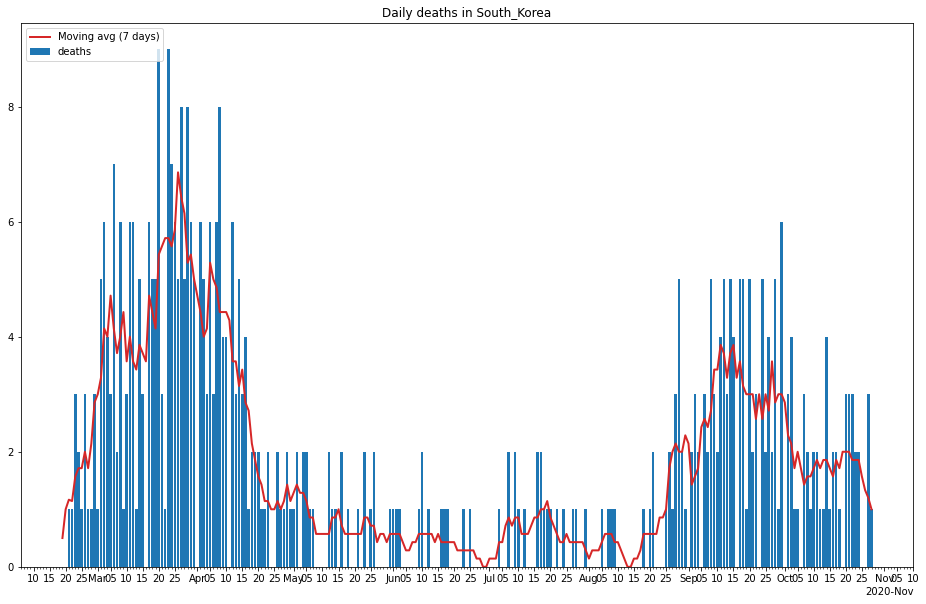

In [27]:
sk.show_deaths()


New daily cases data:
dateRep
2020-10-24    697
2020-10-25    699
2020-10-26    540
2020-10-27    424
2020-10-28    618
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Japan'}>)

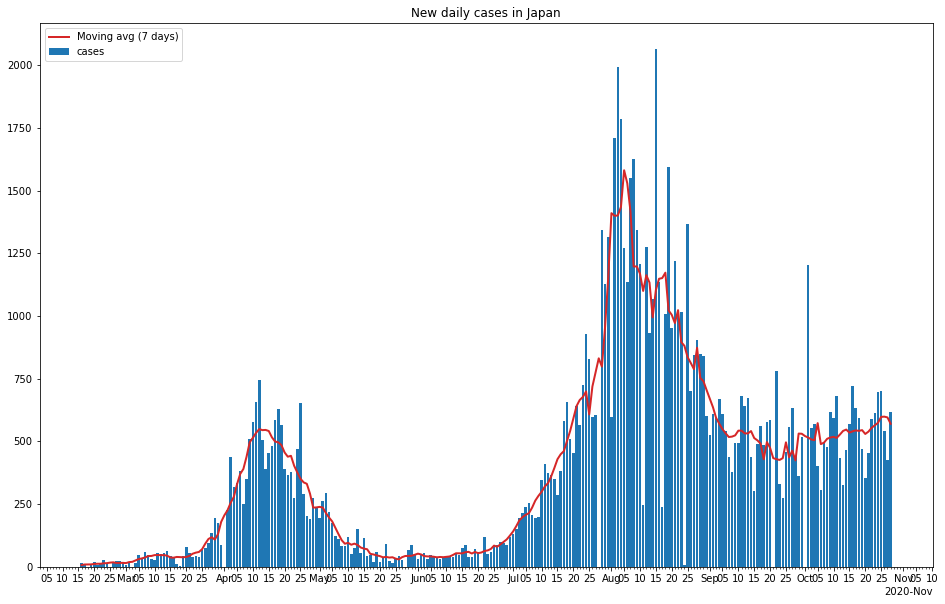

In [28]:
CountryViz('Japan', '2020-02-15', df_raw).show_cases()


Daily deaths data:
dateRep
2020-10-24    12
2020-10-25     5
2020-10-26     7
2020-10-27     7
2020-10-28     5
Name: deaths, dtype: int64


(0.0, 40.0)

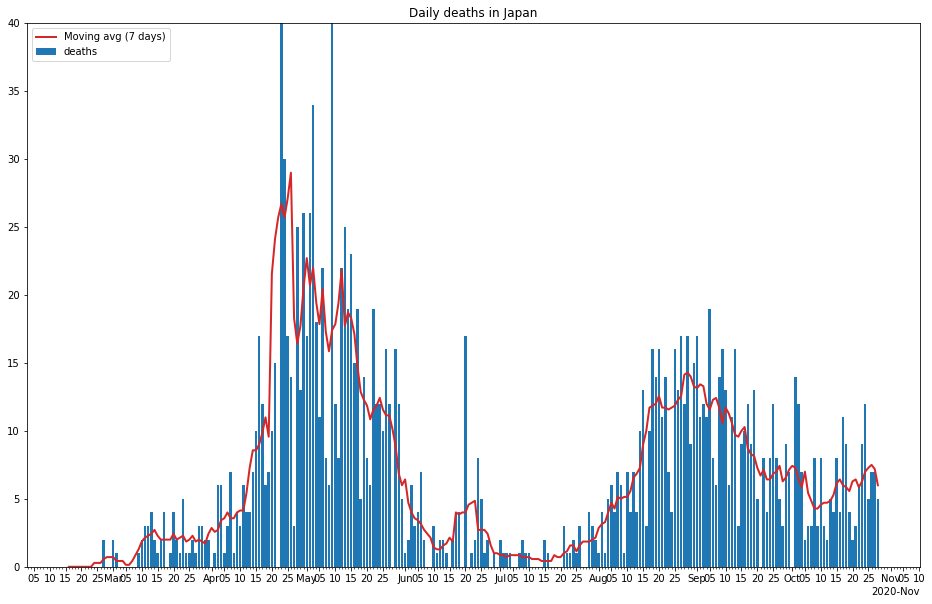

In [29]:
fig, ax = CountryViz('Japan', '2020-02-15', df_raw).show_deaths()
ax.set_ylim(0, 40)


New daily cases data:
dateRep
2020-10-24    30026
2020-10-25    26979
2020-10-26    13493
2020-10-27    15726
2020-10-28    29787
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Brazil'}>)

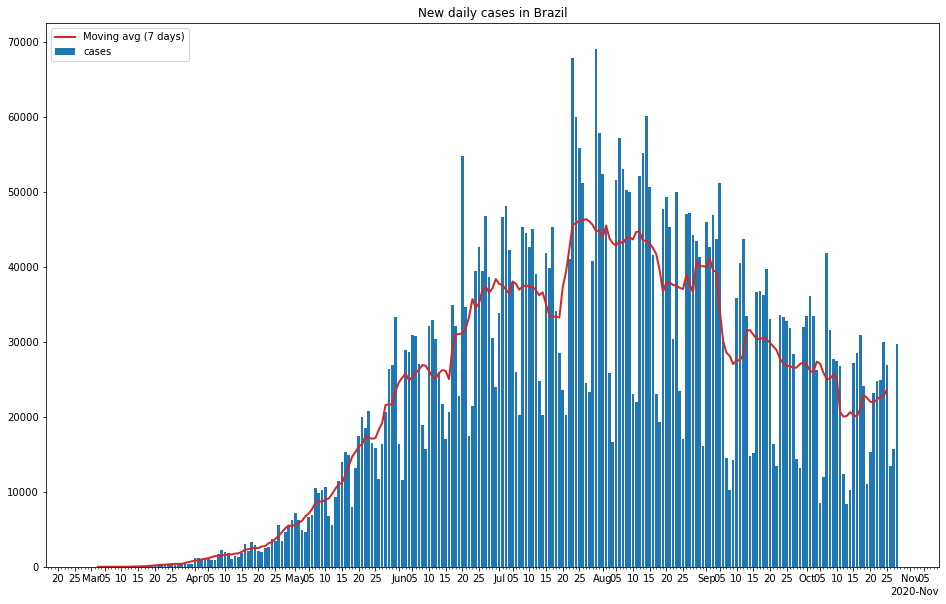

In [70]:
viz = CountryViz('Brazil', '2020-02-28', df_raw)
viz.show_cases()


Daily deaths data:
dateRep
2020-10-24    571
2020-10-25    432
2020-10-26    231
2020-10-27    263
2020-10-28    549
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in Brazil'}>)

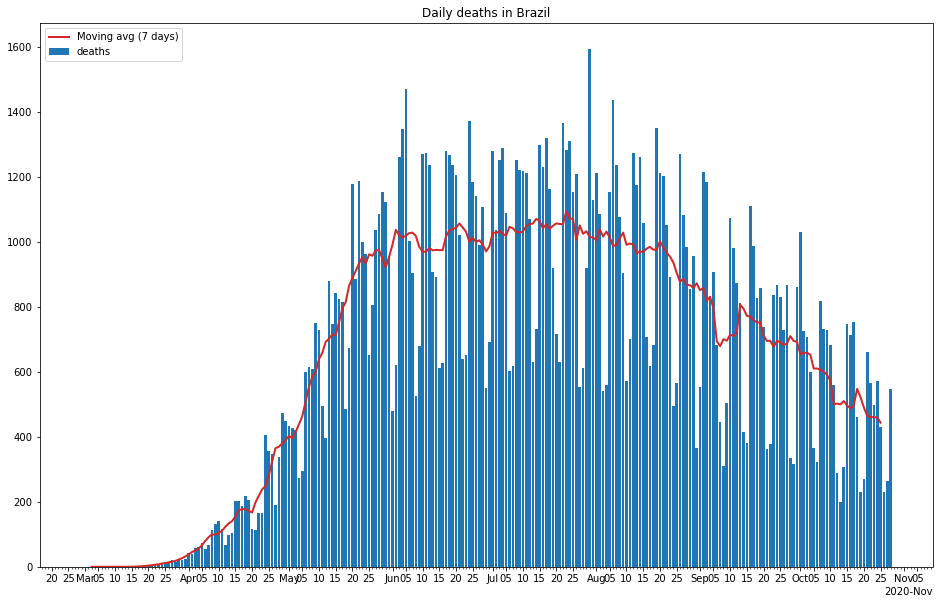

In [71]:
viz.show_deaths()


New daily cases data:
dateRep
2020-10-24    17340
2020-10-25    16521
2020-10-26    16710
2020-10-27    17347
2020-10-28    16550
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Russia'}>)

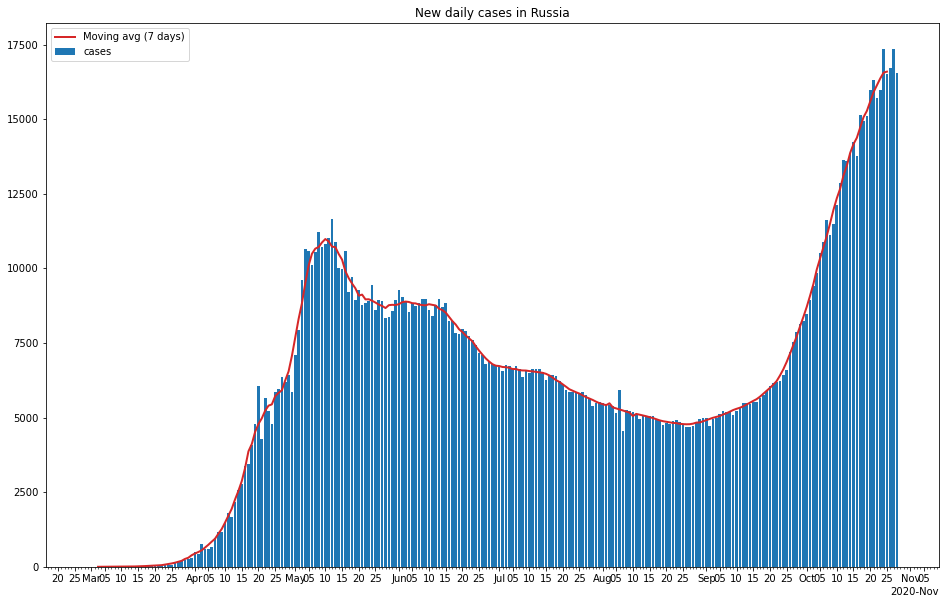

In [72]:
viz = CountryViz('Russia', '2020-02-28', df_raw)
viz.show_cases()


Daily deaths data:
dateRep
2020-10-24    283
2020-10-25    296
2020-10-26    229
2020-10-27    219
2020-10-28    320
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in Russia'}>)

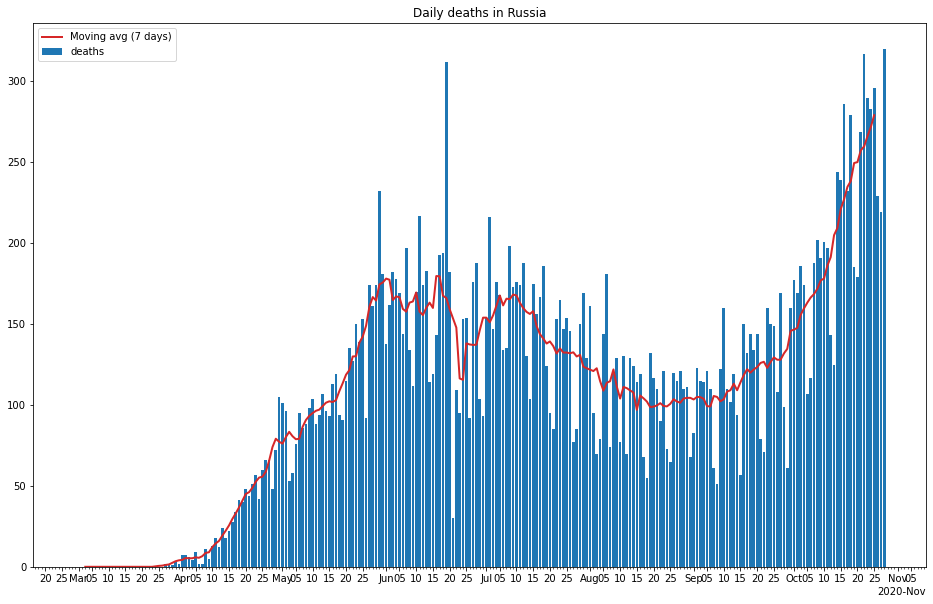

In [73]:
viz.show_deaths()


New daily cases data:
dateRep
2020-10-24    5028
2020-10-25    4761
2020-10-26    3855
2020-10-27    2844
2020-10-28    4724
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Romania'}>)

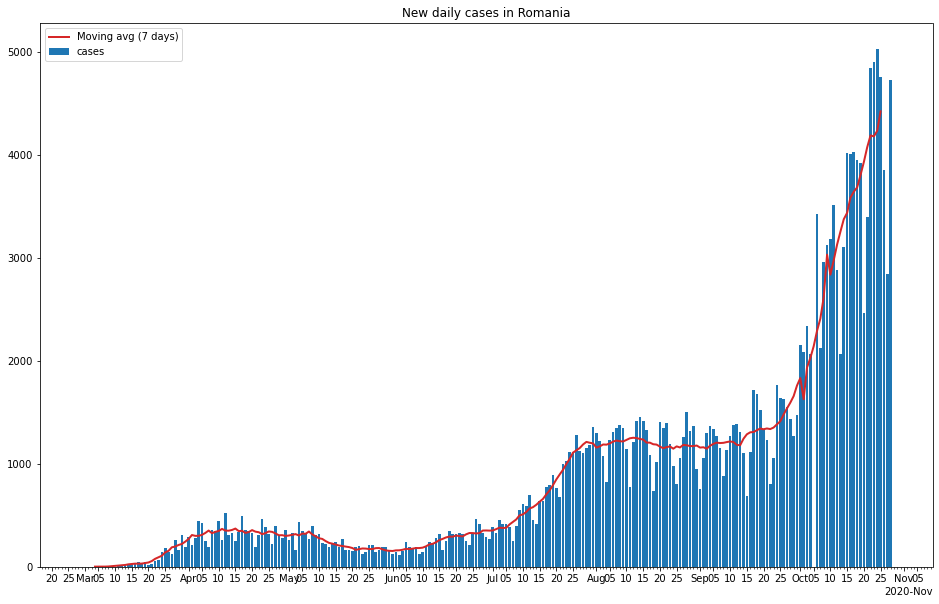

In [74]:
viz = CountryViz('Romania', '2020-02-28', df_raw)
viz.show_cases()


New daily cases data:
dateRep
2020-10-24    7517
2020-10-25    7014
2020-10-26    6079
2020-10-27    5435
2020-10-28    6677
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Ukraine'}>)

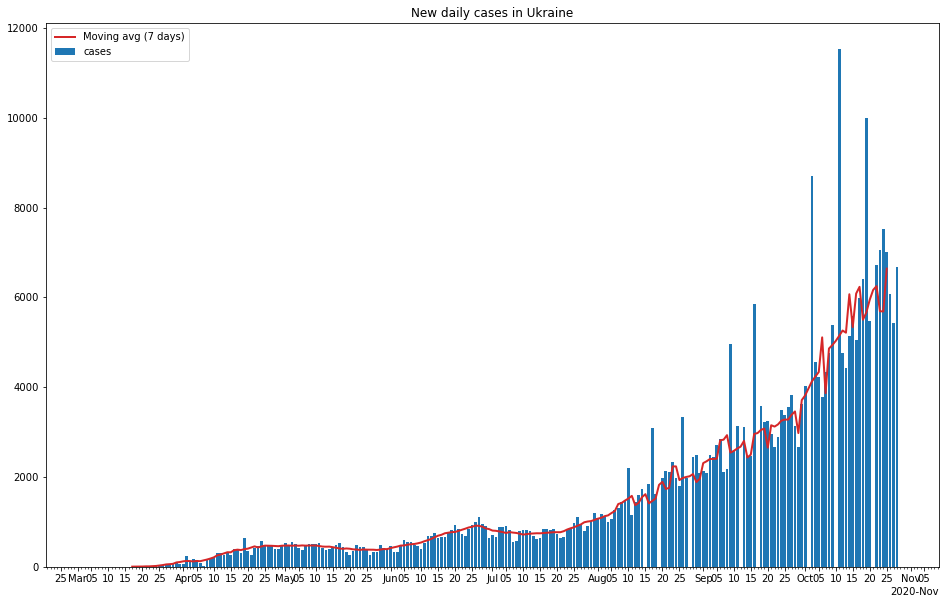

In [75]:
viz = CountryViz('Ukraine', '2020-02-28', df_raw)
viz.show_cases()


New daily cases data:
dateRep
2020-10-24    6134
2020-10-25    5814
2020-10-26    6191
2020-10-27    5960
2020-10-28    6968
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Iran'}>)

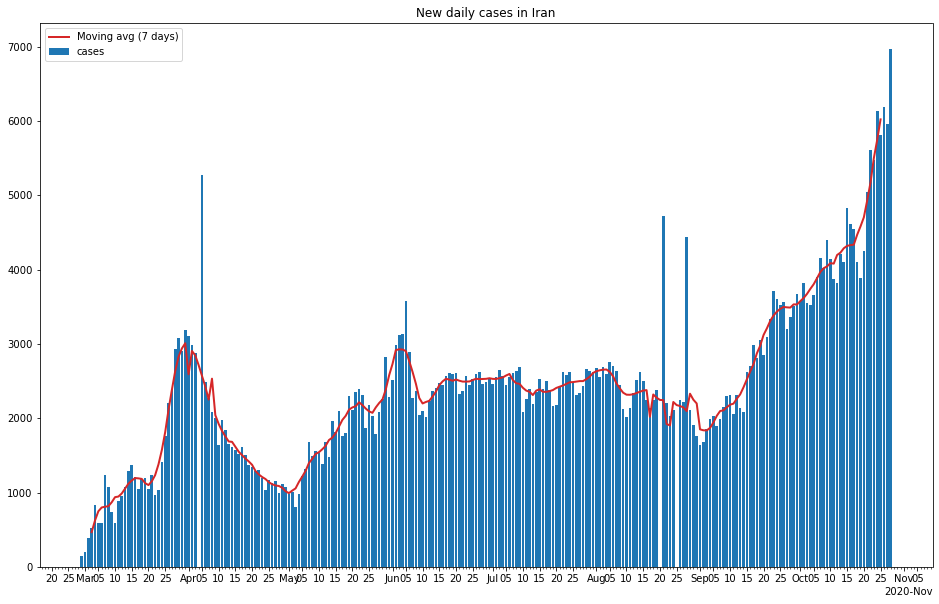

In [76]:
iran = CountryViz('Iran', '2020-02-28', df_raw)
iran.show_cases()


Daily deaths data:
dateRep
2020-10-24    335
2020-10-25    335
2020-10-26    296
2020-10-27    337
2020-10-28    346
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in Iran'}>)

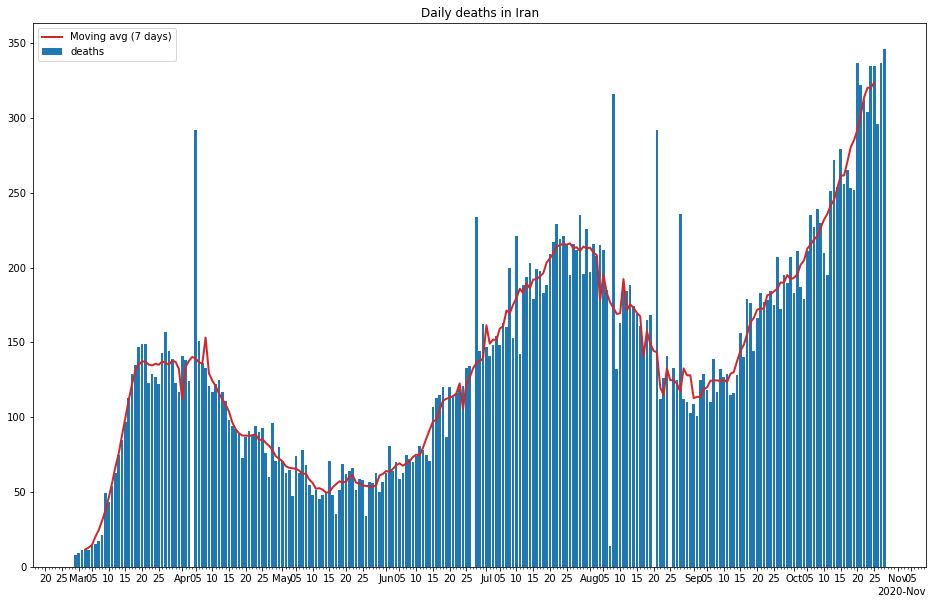

In [77]:
iran.show_deaths()


New daily cases data:
dateRep
2020-10-24    15258
2020-10-25    12474
2020-10-26     7300
2020-10-27    10273
2020-10-28    15663
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Czechia'}>)

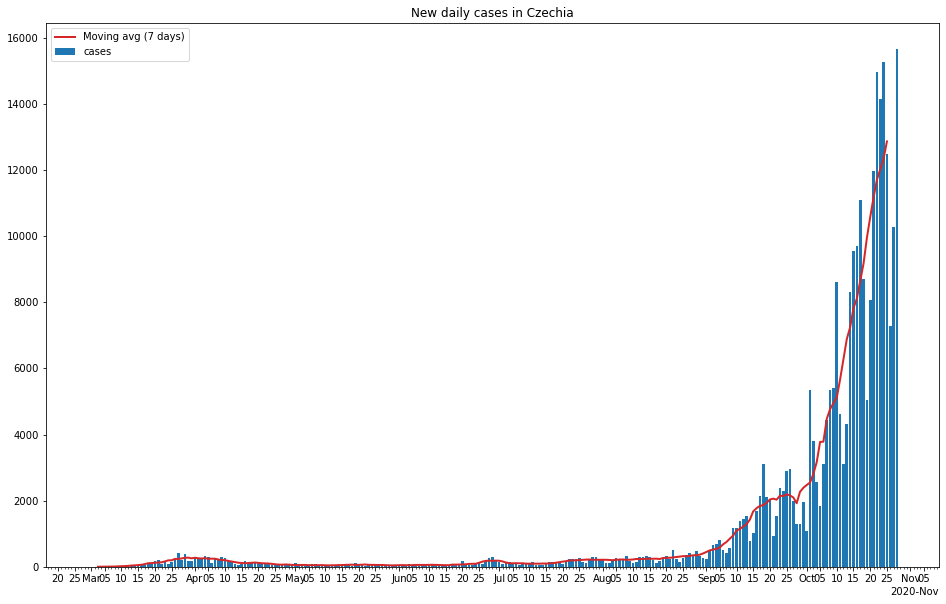

In [78]:
cz = CountryViz('Czechia', '2020-02-28', df_raw)
cz.show_cases()


Daily deaths data:
dateRep
2020-10-24    126
2020-10-25    106
2020-10-26    124
2020-10-27    164
2020-10-28    182
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in Czechia'}>)

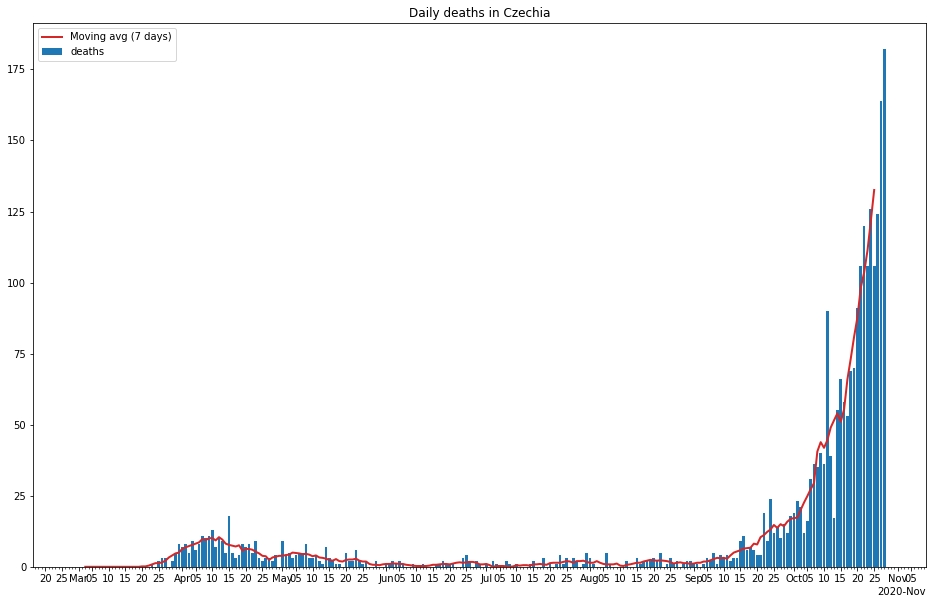

In [79]:
cz.show_deaths()


New daily cases data:
dateRep
2020-10-24    1897
2020-10-25    1834
2020-10-26    1622
2020-10-27     891
2020-10-28    1092
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in South_Africa'}>)

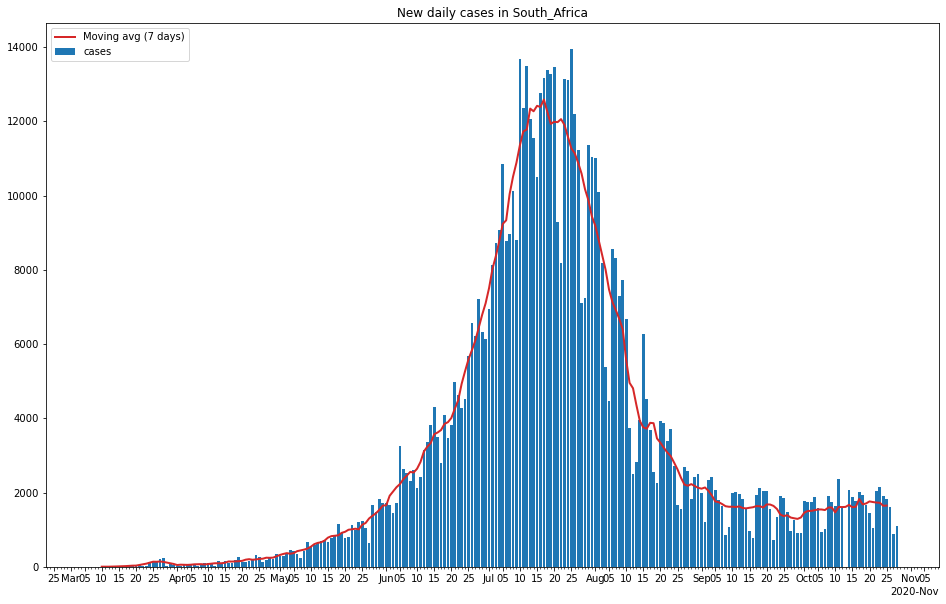

In [80]:
CountryViz('South_Africa', '2020-02-15', df_raw).show_cases()


New daily cases data:
dateRep
2020-10-24    1775
2020-10-25    1636
2020-10-26    1521
2020-10-27    1535
2020-10-28     927
Name: cases, dtype: int64


(0.0, 8000.0)

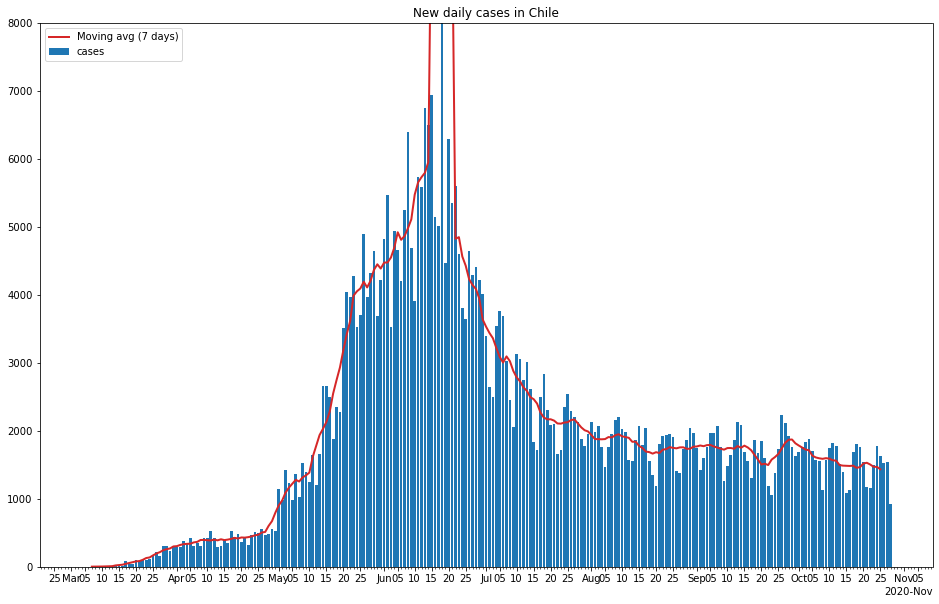

In [81]:
fig, ax = CountryViz('Chile', '2020-02-15', df_raw).show_cases()
ax.set_ylim(None, 8000)


New daily cases data:
dateRep
2020-10-24    18
2020-10-25    15
2020-10-26    21
2020-10-27     7
2020-10-28    14
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Australia'}>)

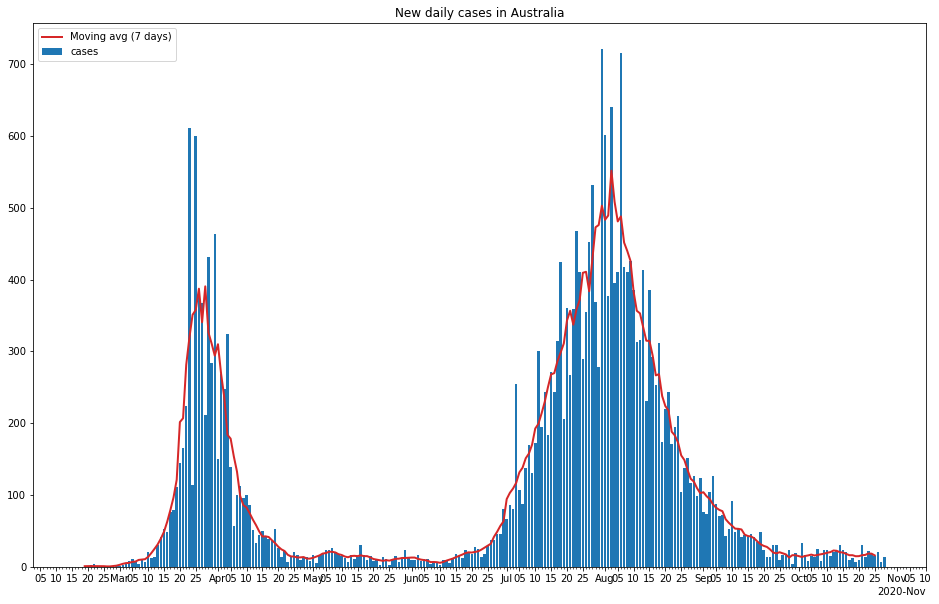

In [82]:
CountryViz('Australia', '2020-02-15', df_raw).show_cases()


New daily cases data:
dateRep
2020-10-24    11
2020-10-25     1
2020-10-26     5
2020-10-27     1
2020-10-28     2
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in New_Zealand'}>)

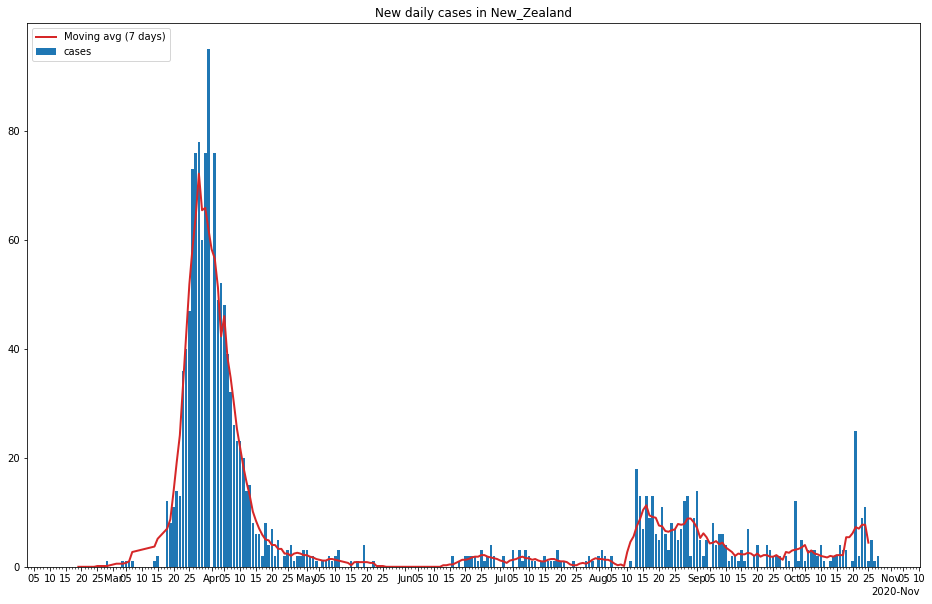

In [83]:
CountryViz('New_Zealand', '2020-02-15', df_raw).show_cases()


New daily cases data:
dateRep
2020-10-24    2584
2020-10-25    2227
2020-10-26    2145
2020-10-27    4109
2020-10-28    2674
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in Canada'}>)

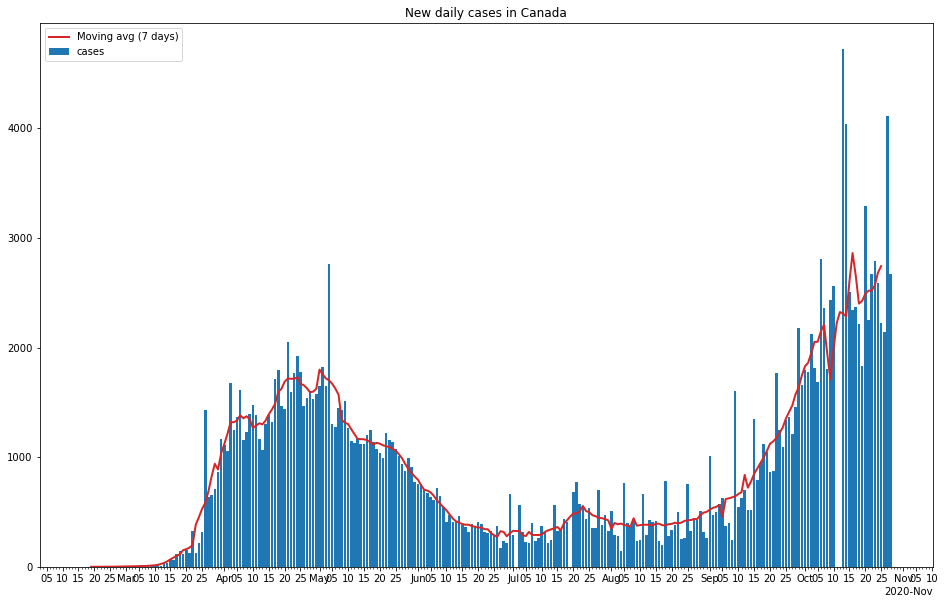

In [84]:
CountryViz('Canada', '2020-02-15', df_raw).show_cases()


New daily cases data:
dateRep
2020-10-24    53370
2020-10-25    50129
2020-10-26    45148
2020-10-27    36470
2020-10-28    43893
Name: cases, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'New daily cases in India'}>)

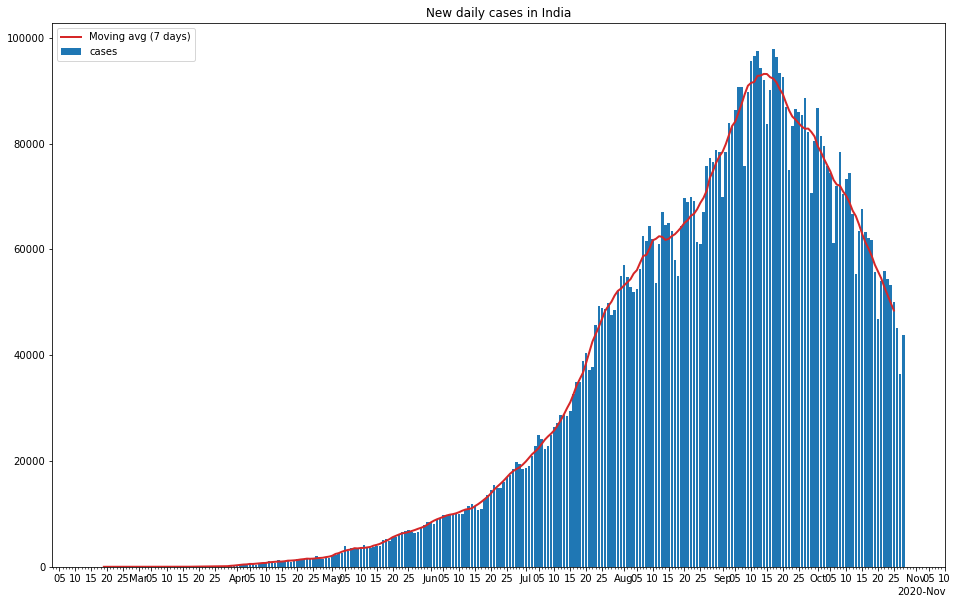

In [85]:
india = CountryViz('India', '2020-02-15', df_raw)
india.show_cases()


Daily deaths data:
dateRep
2020-10-24    650
2020-10-25    578
2020-10-26    480
2020-10-27    488
2020-10-28    508
Name: deaths, dtype: int64


(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Daily deaths in India'}>)

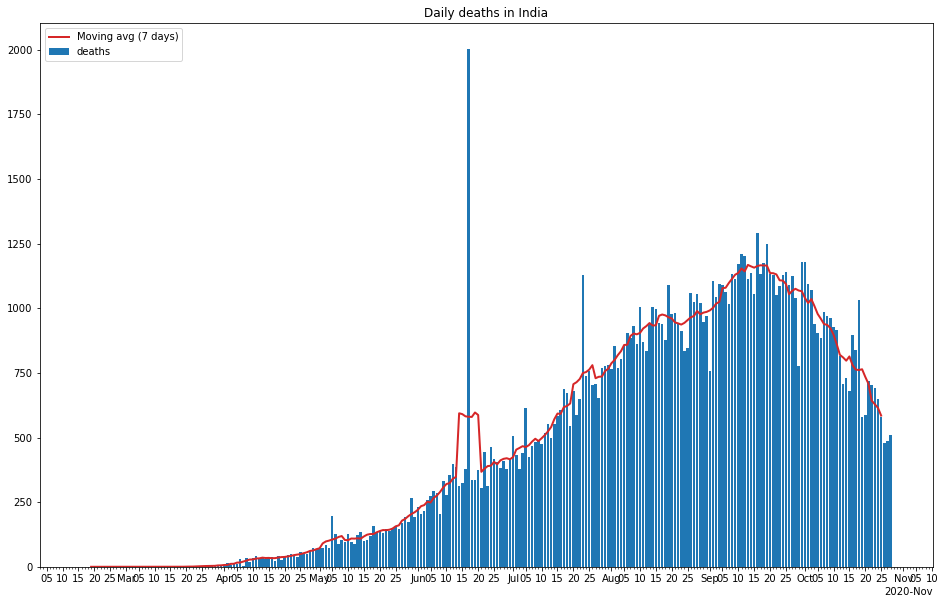

In [86]:
india.show_deaths()


New daily cases data:
dateRep
2020-10-24    33
2020-10-25    19
2020-10-26    26
2020-10-27    24
2020-10-28    42
Name: cases, dtype: int64


(0.0, 5000.0)

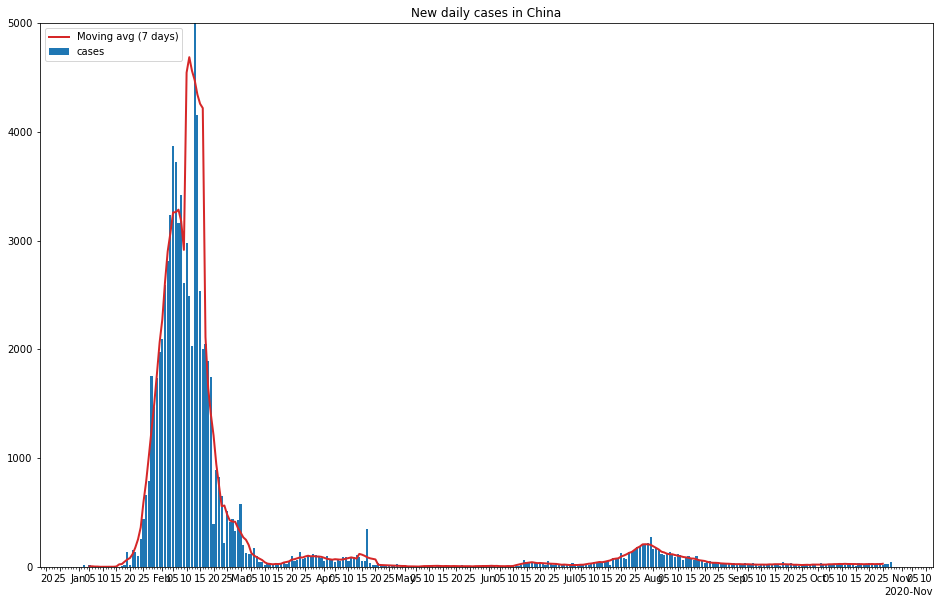

In [87]:
fig, ax = CountryViz('China', '2020-01-01', df_raw).show_cases()
ax.set_ylim(0, 5000)

In [47]:
sorted(df_raw['country'].unique())

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua_and_Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bonaire, Saint Eustatius and Saba',
 'Bosnia_and_Herzegovina',
 'Botswana',
 'Brazil',
 'British_Virgin_Islands',
 'Brunei_Darussalam',
 'Bulgaria',
 'Burkina_Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape_Verde',
 'Cases_on_an_international_conveyance_Japan',
 'Cayman_Islands',
 'Central_African_Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa_Rica',
 'Cote_dIvoire',
 'Croatia',
 'Cuba',
 'CuraÃ§ao',
 'Cyprus',
 'Czechia',
 'Democratic_Republic_of_the_Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican_Republic',
 'Ecuador',
 'Egypt',
 'El_Salvador',
 'Equatorial_Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'F

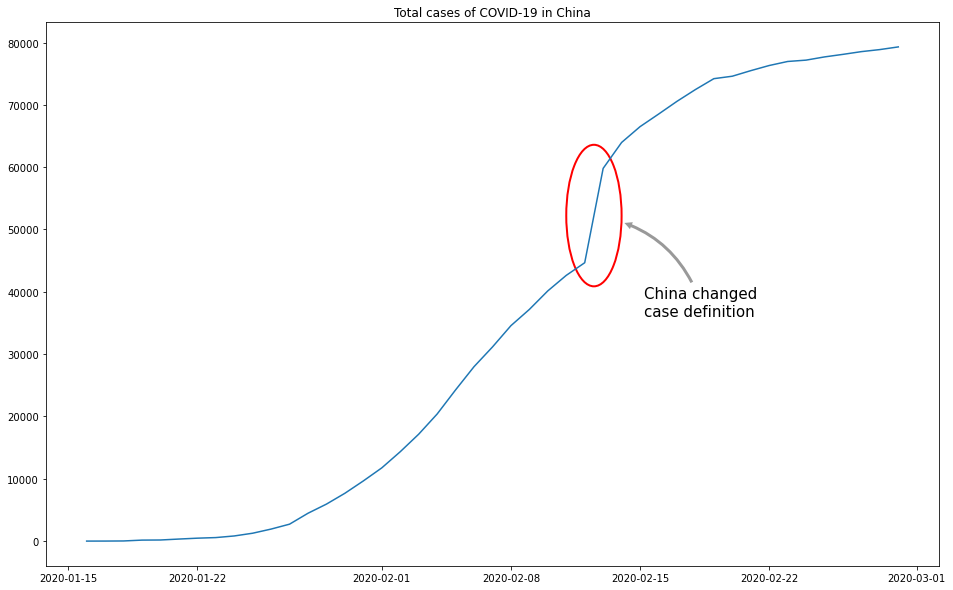

In [48]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(16, 10))
country = 'China'
start = '2020-01-15'
end = '2020-03-01'
country_df = df_raw[(df_raw['country'] == country) & (df_raw.index > start) & (df_raw.index < end)].sort_index()
ax.set_title('Total cases of COVID-19 in China')
cases_exp = country_df['cases'].expanding().sum()
ax.plot(cases_exp)

ann_start = '2020-02-12'
ann_stop = '2020-02-13'

ann_center_x = (mdates.datestr2num(ann_start) + mdates.datestr2num(ann_stop)) / 2
ann_center_y = (cases_exp[ann_start] + cases_exp[ann_stop]) / 2
ann_zoom = 1.5
ann_height = (cases_exp[ann_stop] - cases_exp[ann_start]) * ann_zoom
timespan = mdates.datestr2num(ann_stop) - mdates.datestr2num(ann_start)
ann_width = timespan * 2 * ann_zoom
ellipse = Ellipse(xy=(ann_center_x, ann_center_y), width=ann_width, height=ann_height, edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ax.annotate('China changed\ncase definition',
            xy=(ann_center_x, ann_center_y), xycoords='data',
            xytext=(50, -100), textcoords='offset points',
            size=15,
            arrowprops=dict(arrowstyle="simple",
                            fc="0.6", ec="none",
                            patchB=ellipse,
                            connectionstyle="arc3,rad=0.3"))

plt.show()